# Price Prediction Model 

## Authors
| **Name**              | **NIU**   |
|-----------------------|-----------|
| Arnau Muñoz Barrera   | 1665982   |
| José Ortín López      | 1667573   |

## Objective

This project has the objective of creating a machine learning model to predict car prices based on various features. This project is based on the Kaggle Car Price Prediction Challenge dataset from Kaggle.

## Database

To access the source Database: [Link to Database](https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data)

## Import Libraries

In [291]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.model_selection import train_test_split, RepeatedKFold, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error,r2_score, mean_absolute_error

import warnings
warnings.simplefilter(action='ignore')

## Review Initial Structure and Data

In [292]:
df = pd.read_csv('data/vehicles-dataset.csv', engine='python', on_bad_lines='skip')

df

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7306114308,https://albany.craigslist.org/cto/d/amsterdam-...,albany,https://albany.craigslist.org,22000,1961,chevrolet,c/10,excellent,8 cylinders,...,full-size,pickup,custom,https://images.craigslist.org/00D0D_8nDoJIhfvS...,1961 Chevy C 10 Apache from California no rust...,NaN,ny,42.938700,-74.188200,2021-04-13T09:59:51-0400;;;;;;;;;;;;;;;;;;;;;;...
1,7305844790,https://albany.craigslist.org/ctd/d/east-green...,albany,https://albany.craigslist.org,8250,2011,kia,sorento ex,excellent,6 cylinders,...,sub-compact,SUV,grey,https://images.craigslist.org/00Z0Z_inKLgAQULP...,WOW WE JUST GOT OUR HANDS ON A SUPER CLEAN LOA...,NaN,ny,42.595100,-73.682600,2021-04-12T16:40:04-0400;;;;;;;;;;;;;;;;;;;;;;...
2,7305838951,https://albany.craigslist.org/ctd/d/east-green...,albany,https://albany.craigslist.org,6850,2008,ford,explorer,excellent,6 cylinders,...,mid-size,SUV,black,https://images.craigslist.org/00c0c_izBZsbgBsw...,WE JUST HAD A VERY CLEAN 2008 EXPLORER COME IN...,NaN,ny,42.595100,-73.682600,2021-04-12T16:30:35-0400;;;;;;;;;;;;;;;;;;;;;;...
3,7305835414,https://albany.craigslist.org/ctd/d/east-green...,albany,https://albany.craigslist.org,6250,2006,chevrolet,trailblazer,excellent,6 cylinders,...,mid-size,SUV,silver,https://images.craigslist.org/01212_kfcunili9E...,A NEW ARRIVAL 2006 CHEVY TRAIL BLAZER SIX CYLI...,NaN,ny,42.595100,-73.682600,2021-04-12T16:25:04-0400;;;;;;;;;;;;;;;;;;;;;;...
4,7305832225,https://albany.craigslist.org/ctd/d/east-green...,albany,https://albany.craigslist.org,4250,1999,ford,explorer,excellent,6 cylinders,...,mid-size,SUV,blue,https://images.craigslist.org/00N0N_lbrF4WqKRr...,HERES A RARE FIND A 2 DOOR EXPLORER LOW MILEAG...,NaN,ny,42.595100,-73.682600,2021-04-12T16:19:55-0400;;;;;;;;;;;;;;;;;;;;;;...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,7316750446,https://cincinnati.craigslist.org/cto/d/ripley...,cincinnati,https://cincinnati.craigslist.org,19500,2019,ford,escape sw,excellent,6 cylinders,...,NaN,SUV,silver,https://images.craigslist.org/00P0P_hsazRYyYR9...,Excelent Condition Barely driven by Aunt who...,NaN,oh,38.755100,-83.822700,2021-05-04T11:52:52-0400;;;;;;;;;;;;;;;;;;;;;;...
2926,7316738058,https://cincinnati.craigslist.org/cto/d/cincin...,cincinnati,https://cincinnati.craigslist.org,3000,2005,toyota,sequia,fair,NaN,...,NaN,SUV,silver,https://images.craigslist.org/00606_gBHNb3rxof...,2005 Toyota Sequoia SR5 - $3k Mileage:190k Tr...,NaN,oh,39.210000,-84.395000,2021-05-04T11:32:28-0400;;;;;;;;;;;;;;;;;;;;;;...
2927,7316703359,https://cincinnati.craigslist.org/cto/d/frankl...,cincinnati,https://cincinnati.craigslist.org,7500,2011,toyota,sienna,good,6 cylinders,...,NaN,mini-van,grey,https://images.craigslist.org/00Q0Q_2LPtROjAcc...,New tires New braked New battery New Alternator,NaN,oh,39.495217,-84.351493,2021-05-04T10:33:07-0400;;;;;;;;;;;;;;;;;;;;;;...
2928,7316588386,https://cincinnati.craigslist.org/cto/d/hillsb...,cincinnati,https://cincinnati.craigslist.org,8000,1964,ford,falcon ranchero,good,6 cylinders,...,NaN,truck,black,https://images.craigslist.org/00J0J_fBk4K56k3R...,1964 ford ranchero 6cyl 3 speed manual trans. ...,NaN,oh,39.167900,-83.606400,2021-05-03T23:56:04-0400;;;;;;;;;;;;;;;;;;;;;;...


## 1. Data analysis

In this section, the goal is treat the attributes of the dataset before train the model.

### 1.1 Attributes values correction

First of all let's see all the possible values that each attribute can take to see if there are any mistake due to the format of the dataset.

In [293]:
for column in df.columns:
    print(f"'{column}':")
    print(df[column].unique())
    print("\n")

'id':
['7306114308' '7305844790' '7305838951' ... '7316703359' '7316588386'
 '7316492455']


'url':
['https://albany.craigslist.org/cto/d/amsterdam-1961-chevy-10-apache/7306114308.html'
 'https://albany.craigslist.org/ctd/d/east-greenbush-kia-sorento/7305844790.html'
 'https://albany.craigslist.org/ctd/d/east-greenbush-ford-explorer/7305838951.html'
 ...
 'https://cincinnati.craigslist.org/cto/d/franklin-2011-toyota-sienna-xle/7316703359.html'
 'https://cincinnati.craigslist.org/cto/d/hillsboro-1964-ford-ranchero/7316588386.html'
 'https://cincinnati.craigslist.org/cto/d/mason-2016-mack-for-sale/7316492455.html']


'region':
['albany' 'binghamton' 'buffalo' 'catskills' 'chautauqua' 'elmira-corning'
 'finger lakes' 'glens falls' 'hudson valley' 'ithaca' 'long island' None
 'new york city' ' sin crédito' 'oneonta' 'plattsburgh-adirondacks'
 'potsdam-canton-massena' 'rochester' 'syracuse' 'twin tiers NY/PA'
 'utica-rome-oneida' 'watertown' 'new hampshire' 'bismarck' 'grand forks'
 'north 

## Data cleaning decisions

### Trim string columns
Many values start with a leading space (e.g. `" desempleo"`, `" SSI"`).  
➜ Strip whitespace from all object (string) columns.

---

### `region` / `region_url`
Some entries are Spanish marketing phrases instead of regions/URLs (`"sin crédito"`, `"desempleo"`) and there are missing values.  
➜ Replace those invalid phrases with `NaN`. Keep valid region names and Craigslist URLs.

---

### `price`
Almost all values are numeric strings, but there are some non-numeric values such as `"discapacidad"` and `None`.  
➜ Replace obvious non-numeric strings with `NaN`, then convert the column to numeric with `errors='coerce'` so any other strange value becomes `NaN`.

---

### `year`
The column mostly contains valid years as strings plus `NaN`, `None`, and the noise value `"SSI"`.  
➜ Replace `"SSI"` with `NaN`, then convert to numeric with `errors='coerce'`.

---

### `manufacturer`
Values like `"recuperaciones anteriores"` are not car brands.  
➜ Replace such phrases with `NaN`. Keep valid manufacturers (`"chevrolet"`, `"ford"`, `"bmw"`, etc.).

---

### Categorical columns with injected Spanish text
Columns `condition`, `cylinders`, `fuel`, `title_status`, and `transmission` contain valid categories (e.g. `"excellent"`, `"6 cylinders"`, `"gas"`, `"clean"`, `"automatic"`) but also Spanish phrases like `"extractos bancarios"`, `"quiebra"`, `"compradores por primera vez"`, `"los ingresos en efectivo"`, and a long sentence about “situación financiera difícil…”.  
➜ Replace those Spanish phrases with `NaN`, keeping only meaningful car-related categories.

---

### `VIN`
Most entries are VIN-like codes, but a few values are long marketing sentences (starting with “aqui en Adams Auto Group le ayudaremos con un vehiculo…”).  
➜ Replace those marketing sentences with `NaN`. (Short or non-17-char VINs may still be valid for older vehicles, so we keep them.)

---

### `odometer`
Values are numeric strings (kilometers/miles).  
➜ Convert to numeric with `errors='coerce'` to ensure a clean numeric column.

---

### `posting_date`
Each value is a timestamp followed by many `;` characters (e.g. `"2021-04-13T09:59:51-0400;;;;;;;;;;;;;;;;;;;;"`).  
➜ Keep only the part before the first `;` and then convert to `datetime`.

---

### `county`
The column is entirely missing (`NaN`). It does not add information for modeling.  
➜ Drop the `county` column.

---

### Other columns
Columns like `id`, `url`, `model`, `drive`, `size`, `type`, `paint_color`, `image_url`, `description`, `state`, `lat`, `long` look structurally fine. We just benefit from trimming whitespace on string columns (already covered in the first step).


In [294]:
import numpy as np
import pandas as pd

# 1. Strip whitespace from all object (string) columns
obj_cols = df.select_dtypes(include='object').columns
df[obj_cols] = df[obj_cols].apply(lambda s: s.str.strip())

# 2. Fix region / region_url
df['region'] = df['region'].replace({
    'sin crédito': np.nan
})

df['region_url'] = df['region_url'].replace({
    'desempleo': np.nan
})

# 3. Clean price and convert to numeric
df['price'] = df['price'].replace({
    'discapacidad': np.nan
})
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# 4. Clean year and convert to numeric
df['year'] = df['year'].replace({
    'SSI': np.nan
})
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# 5. Fix manufacturer
df['manufacturer'] = df['manufacturer'].replace({
    'recuperaciones anteriores': np.nan
})

# 6. Clean categorical columns with Spanish noise
df['condition'] = df['condition'].replace({
    'extractos bancarios': np.nan
})

df['cylinders'] = df['cylinders'].replace({
    'quiebra': np.nan
})

df['fuel'] = df['fuel'].replace({
    'compradores por primera vez': np.nan
})

df['title_status'] = df['title_status'].replace({
    'los ingresos en efectivo': np.nan
})

df['transmission'] = df['transmission'].replace({
    'Si se encuentra en una situación financiera difícil y necesita mejorar su puntuación de crédito': np.nan
})

# 7. Clean VIN: remove marketing sentences
vin_noise_values = [
    "aqui en Adams Auto Group le ayudaremos con un vehiculo. Todos son aprovados. ;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;",
    "aqui en Adams Auto Group le ayudaremos con un vehiculo. Todos son aprovados.;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;"
]

df['VIN'] = df['VIN'].replace({v: np.nan for v in vin_noise_values})

# 8. Convert odometer to numeric
df['odometer'] = pd.to_numeric(df['odometer'], errors='coerce')

# 9. Clean posting_date: remove trailing semicolons and cast to datetime
df['posting_date'] = df['posting_date'].str.split(';').str[0]
df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce')

# 10. Drop county column (all NaN)
df = df.drop(columns=['county'])

# 11. Convert selected categorical fields to numeric codes for correlation/EDA
cat_for_corr = ["cylinders", "fuel", "size", "type", "paint_color"]

for col in cat_for_corr:
    # Convert to categorical and then to integer codes
    df[col] = df[col].astype('category')
    # .cat.codes asigna -1 a los NaN; lo revertimos a NaN para no falsear las métricas
    df[col] = df[col].cat.codes.replace(-1, np.nan)


# Show cleaned dataframe 
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,7306114308,https://albany.craigslist.org/cto/d/amsterdam-...,albany,https://albany.craigslist.org,22000.0,1961.0,chevrolet,c/10,excellent,5.0,...,rwd,1.0,8.0,3.0,https://images.craigslist.org/00D0D_8nDoJIhfvS...,1961 Chevy C 10 Apache from California no rust...,ny,42.9387,-74.1882,2021-04-13 09:59:51-04:00
1,7305844790,https://albany.craigslist.org/ctd/d/east-green...,albany,https://albany.craigslist.org,8250.0,2011.0,kia,sorento ex,excellent,4.0,...,4wd,3.0,0.0,5.0,https://images.craigslist.org/00Z0Z_inKLgAQULP...,WOW WE JUST GOT OUR HANDS ON A SUPER CLEAN LOA...,ny,42.5951,-73.6826,2021-04-12 16:40:04-04:00
2,7305838951,https://albany.craigslist.org/ctd/d/east-green...,albany,https://albany.craigslist.org,6850.0,2008.0,ford,explorer,excellent,4.0,...,4wd,2.0,0.0,0.0,https://images.craigslist.org/00c0c_izBZsbgBsw...,WE JUST HAD A VERY CLEAN 2008 EXPLORER COME IN...,ny,42.5951,-73.6826,2021-04-12 16:30:35-04:00
3,7305835414,https://albany.craigslist.org/ctd/d/east-green...,albany,https://albany.craigslist.org,6250.0,2006.0,chevrolet,trailblazer,excellent,4.0,...,4wd,2.0,0.0,9.0,https://images.craigslist.org/01212_kfcunili9E...,A NEW ARRIVAL 2006 CHEVY TRAIL BLAZER SIX CYLI...,ny,42.5951,-73.6826,2021-04-12 16:25:04-04:00
4,7305832225,https://albany.craigslist.org/ctd/d/east-green...,albany,https://albany.craigslist.org,4250.0,1999.0,ford,explorer,excellent,4.0,...,4wd,2.0,0.0,1.0,https://images.craigslist.org/00N0N_lbrF4WqKRr...,HERES A RARE FIND A 2 DOOR EXPLORER LOW MILEAG...,ny,42.5951,-73.6826,2021-04-12 16:19:55-04:00


To continue, let's see the types of each attribute of the dataset.

In [295]:
df.dtypes

id               object
url              object
region           object
region_url       object
price           float64
year            float64
manufacturer     object
model            object
condition        object
cylinders       float64
fuel            float64
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size            float64
type            float64
paint_color     float64
image_url        object
description      object
state            object
lat             float64
long            float64
posting_date     object
dtype: object

### Converting Object Columns to Proper Numeric and Datetime Types

Several attributes in the dataset are still stored as **object** type, even though their
contents represent numeric values or dates. Properly converting these fields ensures
they can be used reliably for modeling and statistical analysis.

- **price**, **odometer**, and **year** have already been cleaned but may still require
  explicit conversion depending on previous steps.
- **posting_date** remains an object because the raw strings contain unnecessary
  semicolons (e.g., `"2021-04-13T09:59:51-0400;;;;;;;;;;;;;;;;;;;;"`), and in some cases
  the column may contain mixed types. This prevents the use of the `.str` accessor.
  To fix this, we first cast the entire column to string, remove everything after the
  first semicolon, and finally convert the cleaned value to a proper `datetime`.
- The **VIN** column stays as object because VINs are identifiers, not numeric data.

To correct these issues, we will:

1. Convert `price`, `year`, and `odometer` into numeric types (if not already converted).
2. Clean and convert `posting_date` into a proper `datetime` object.

In [ ]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['odometer'] = pd.to_numeric(df['odometer'], errors='coerce')

df['posting_date'] = df['posting_date'].astype(str).str.split(';').str[0]
df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce')

df.dtypes

id               object
url              object
region           object
region_url       object
price           float64
year            float64
manufacturer     object
model            object
condition        object
cylinders       float64
fuel            float64
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size            float64
type            float64
paint_color     float64
image_url        object
description      object
state            object
lat             float64
long            float64
posting_date     object
dtype: object

This is the table with the attributes of the dataset after treatment:

### Attribute Table After Data Treatment

| **Variable**     | **Definition**                                      | **Key / Notes**                                                                 | **Type**     |
|------------------|------------------------------------------------------|----------------------------------------------------------------------------------|--------------|
| `id`             | Unique identifier of the listing                     | Craigslist internal ID                                                           | Categorical  |
| `url`            | URL of the vehicle listing                           | Direct link to the post                                                          | Categorical  |
| `region`         | Geographic region of the listing                     | e.g., *albany, buffalo, cincinnati*                                              | Categorical  |
| `region_url`     | Base URL of the Craigslist region                    | e.g., `https://albany.craigslist.org`                                            | Categorical  |
| `price`          | Listing price of the vehicle                         | Numeric price in USD                                                             | Numeric      |
| `year`           | Manufacturing year of the vehicle                    | e.g., 1999, 2015, 2020                                                            | Numeric      |
| `manufacturer`   | Brand of the vehicle                                 | e.g., *ford, chevrolet, toyota, bmw*                                             | Categorical  |
| `model`          | Model name of the vehicle                            | Free-text input                                                                   | Categorical  |
| `condition`      | Stated physical condition of the vehicle             | excellent, good, fair, like new, salvage, new                                    | Categorical  |
| `cylinders`      | Number of cylinders                                  | 3, 4, 5, 6, 8, 10, other                                                          | Categorical  |
| `fuel`           | Type of fuel used                                    | gas, diesel, hybrid, electric, other                                             | Categorical  |
| `odometer`       | Reported mileage of the vehicle                      | Numeric mileage                                                                   | Numeric      |
| `title_status`   | Legal title condition                                | clean, salvage, rebuilt, lien, missing                                            | Categorical  |
| `transmission`   | Transmission type                                    | automatic, manual, other                                                          | Categorical  |
| `VIN`            | Vehicle Identification Number                        | Could be missing or incomplete                                                    | Categorical  |
| `drive`          | Drive type                                           | rwd, fwd, 4wd                                                                      | Categorical  |
| `size`           | Vehicle size category                                | full-size, mid-size, compact, sub-compact                                        | Categorical  |
| `type`           | Body type                                            | sedan, SUV, pickup, hatchback, coupe, van, wagon, etc.                            | Categorical  |
| `paint_color`    | Exterior color                                       | e.g., black, white, blue, red                                                     | Categorical  |
| `image_url`      | URL of main listing image                            | Link to Craigslist-hosted image                                                   | Categorical  |
| `description`    | Seller's text description                            | Unstructured text                                                                 | Categorical  |
| `state`          | US state shorthand                                   | ny, oh, nh, nd                                                                    | Categorical  |
| `lat`            | Latitude of listing location                         | GPS coordinate                                                                    | Numeric      |
| `long`           | Longitude of listing location                        | GPS coordinate                                                                    | Numeric      |
| `posting_date`   | Date when the listing was posted                     | Cleaned to proper `datetime` format                                               | Datetime     |


## 2. Preprocessing

In this chapter, the objective is to prepare the dataset before training the model to achieve the best results. The first step will be to split the dataset into training and testing sets, allowing us to work on them separately and prevent data leakage.

In [297]:
y=df['price']
X=df.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

Let's examine the percentage of NaN values in the training dataset.

In [298]:
percent_nan_col = train.isna().mean(axis=0)
percent_nan_col

id              0.000000
url             0.135239
region          0.182594
region_url      0.182594
year            0.183874
manufacturer    0.236775
model           0.194539
condition       0.353242
cylinders       0.404863
fuel            0.183874
odometer        0.183874
title_status    0.183874
transmission    0.183874
VIN             0.897611
drive           0.440700
size            0.611348
type            0.486775
paint_color     0.447952
image_url       0.183874
description     0.183874
state           0.182594
lat             0.185154
long            0.185154
posting_date    0.183874
price           0.182594
dtype: float64

## 2.1 Outlier removals

Now, let's check if there is any correlation between the attributes of the training set and the target variable, Price. By doing this, the data leakage will be avoided. Firstly, the correlations will be calculated for the numeric attributes, excluding the NaN values.

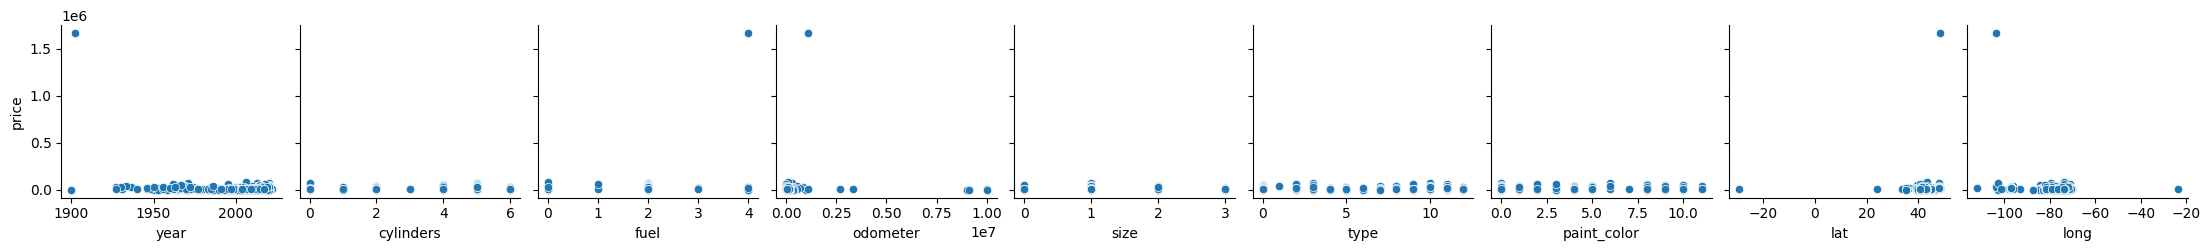

In [299]:
g= sns.pairplot(train,y_vars=['price'], x_vars=df.select_dtypes(include='number').columns.drop('price'), dropna=True)

This pairplot reveals the presence of a few extreme outliers in the price variable, particularly for certain values of year, odometer, and geographic coordinates (lat/long). Before proceeding with further analysis or modeling, it will be necessary to examine and address these anomalous observations to avoid distortions in the results.

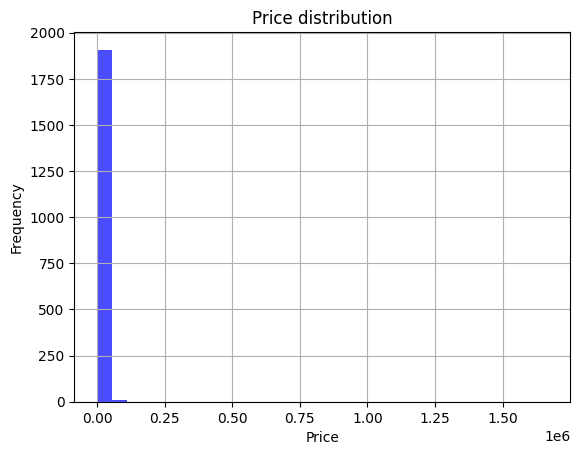

In [300]:
train['price'].hist(bins=30, color='blue', alpha=0.7)
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

This histogram clearly indicates the presence of one extreme outlier in the price variable. While nearly all vehicles fall within a reasonable price range, one listing reaches values close to $1.7 million, far beyond the rest of the distribution. Such an anomalous value can heavily distort statistical measures and model performance, so it should be removed before proceeding with further analysis.

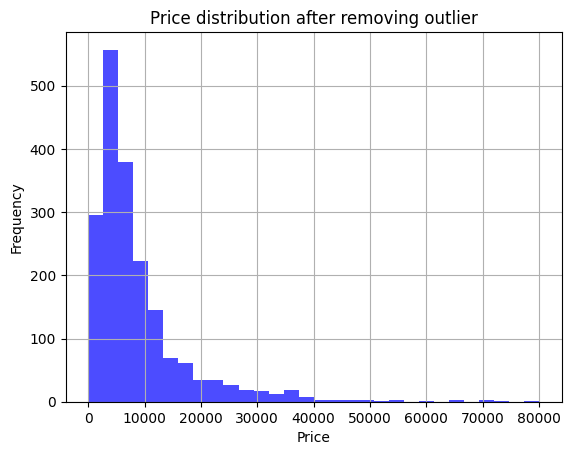

In [ ]:
train = train.drop(index=train['price'].idxmax())

train['price'].hist(bins=30, color='blue', alpha=0.7)
plt.title('Price distribution after removing outlier')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

The distribution of the training set is asymmetric to the left, so let's combine the percentile and quantile methods to address this issue.

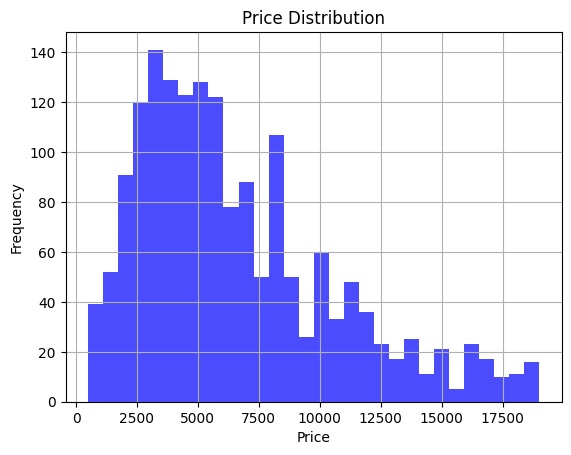

In [302]:
lower_percentile = train['price'].quantile(0.02)
upper_percentile = train['price'].quantile(0.98)

train = train[(train['price'] >= lower_percentile) & (train['price'] <= upper_percentile)]

Q1=train['price'].quantile(0.25)
Q3=train['price'].quantile(0.75)
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR

train = train[(train['price'] >= lower_bound) & (train['price'] <= upper_bound)]

train['price'].hist(bins=30, color='blue', alpha=0.7)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

Before proceeding, the test dataset must experience the same outlier processing as the training dataset.

In [303]:
test = test[(test['price'] >= lower_percentile) & (test['price'] <= upper_percentile)]
test = test[(test['price'] >= lower_bound) & (test['price'] <= upper_bound)]

### Feature Engineering and Model Input Preparation



In [ ]:
import numpy as np

df_clean = df.copy()

df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
df_clean['year'] = pd.to_numeric(df_clean['year'], errors='coerce')
df_clean['odometer'] = pd.to_numeric(df_clean['odometer'], errors='coerce')

numeric_cols = ["year", "odometer", "cylinders", "fuel", "size", "type", "paint_color"]

df_metrics = df_clean[['price'] + numeric_cols].dropna()

df_metrics.head()

,price,year,odometer,cylinders,fuel,size,type,paint_color
0,22000.0,1961.0,85000.0,5.0,2.0,1.0,8.0,3.0
1,8250.0,2011.0,137369.0,4.0,2.0,3.0,0.0,5.0
2,6850.0,2008.0,126461.0,4.0,2.0,2.0,0.0,0.0
3,6250.0,2006.0,109566.0,4.0,2.0,2.0,0.0,9.0
4,4250.0,1999.0,112566.0,4.0,2.0,2.0,0.0,1.0


## 2.2 Correlations and feature selection

Now, finally, let's examine the correlations between the attributes and the target.

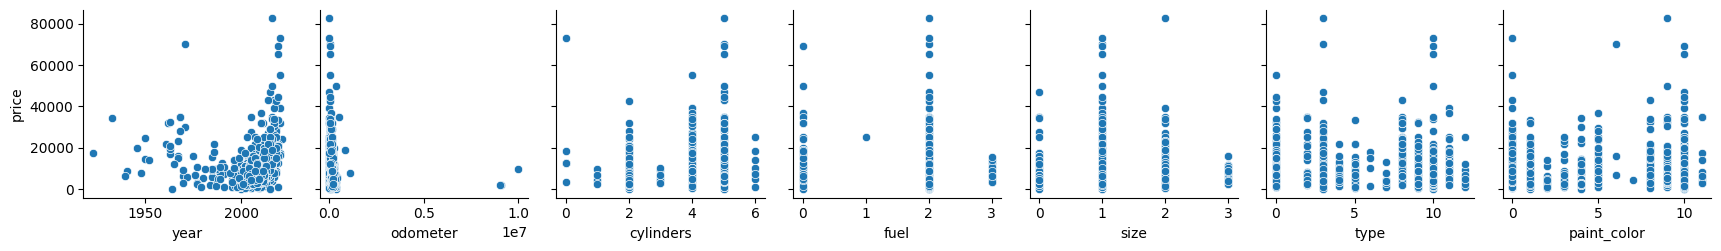

In [305]:
import seaborn as sns

sns.pairplot(
    df_metrics,
    y_vars=['price'],   
    x_vars=df_metrics.columns.drop('price'),
    dropna=True
)


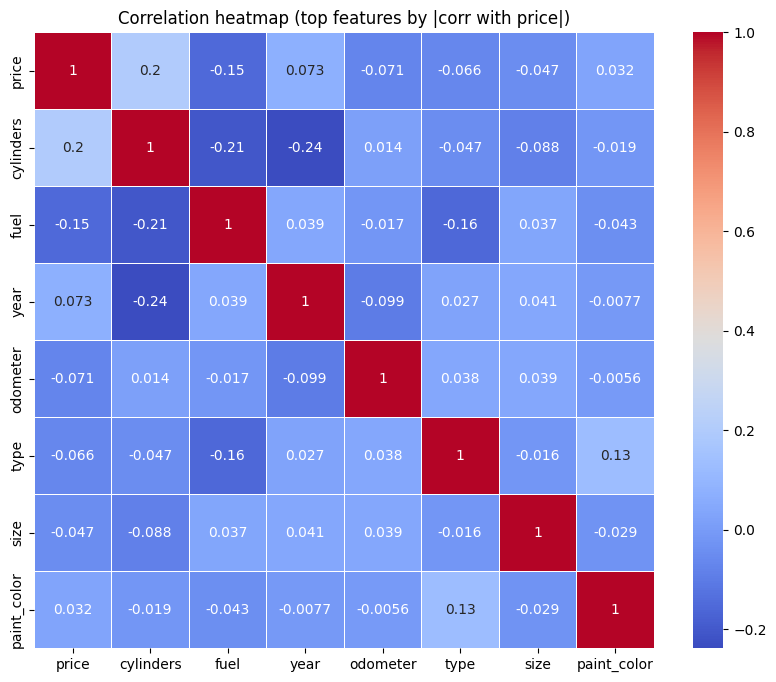

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_metrics.corr(numeric_only=True)

k = 15 
top_features = corr['price'].abs().sort_values(ascending=False).head(k).index

corr_top = corr.loc[top_features, top_features]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_top, annot=True, linewidths=0.5, cmap="coolwarm")
plt.title("Correlation heatmap (top features by |corr with price|)")
plt.show()

The analysis shows that cylinders is the attribute most strongly correlated with the target variable price (≈ 0.20), while all other numerical features—such as fuel, year, odometer, type, size, and paint_color—exhibit weak correlations below 0.1 in absolute value.

### Encoding and normalization

Before encoding, it may be useful to combine the Manufacturer and Model columns into a single feature, as vehicles from the same brand can have different price ranges.

The best encoding method is TargetEncoder, as it considers the relationship between categories and the target value. To ensure consistency, the train and test sets should be combined before applying the encoding.

In [307]:
n_train = train.shape[0]
df = pd.concat([train, test], axis=0)
df['car'] = df['manufacturer'] + ' ' + df['model']

X=df.drop(columns=['price'])
y=df['price']

te= TargetEncoder()
df_aux = te.fit_transform(X,y)
df_aux=pd.concat([df_aux, y], axis=1)
df = pd.DataFrame(df_aux, columns=df.columns)

df

,id,url,region,region_url,year,manufacturer,model,condition,cylinders,fuel,...,type,paint_color,image_url,description,state,lat,long,posting_date,price,car
381,6500.771297,6500.771297,6650.616175,6650.616175,2007.0,6936.515504,6500.771297,5316.598194,NaN,2.0,...,NaN,NaN,6500.771297,6500.771297,6401.982029,43.087800,-73.600700,6500.771297,5999.0,6500.771297
834,6362.986423,6362.986423,6363.124579,6363.124579,2014.0,5903.384505,6239.041139,8054.628202,2.0,2.0,...,4.0,4.0,6362.986423,6362.986423,6401.982029,40.789252,-72.818869,6362.986423,4940.0,6239.041139
1898,6409.825473,6409.825473,6922.820985,6922.820985,2010.0,7919.001625,6246.018783,5691.110155,4.0,2.0,...,0.0,8.0,6409.825473,6409.825473,6401.982029,44.724965,-75.317272,6409.825473,5300.0,6246.018783
678,6364.287507,6364.287507,4927.375465,4927.375465,2013.0,6375.765716,6385.624058,8132.484050,2.0,2.0,...,9.0,NaN,6364.287507,6364.287507,6401.982029,41.391700,-73.453200,6364.287507,4950.0,6385.624058
700,6370.142389,6370.142389,6520.059978,6520.059978,2009.0,6887.010490,4860.156589,8132.484050,5.0,2.0,...,11.0,10.0,6351.579460,6370.142389,6401.982029,43.078400,-77.337200,6370.142389,4995.0,6214.821913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,6604.988185,6604.988185,7461.764466,7461.764466,2011.0,6874.909363,6515.417440,8132.484050,2.0,2.0,...,NaN,0.0,6515.417440,6515.417440,6401.982029,44.211300,-75.801400,6604.988185,6800.0,6214.821913
456,6143.103101,6143.103101,4927.375465,4927.375465,2010.0,5919.439506,5388.161839,8132.484050,2.0,2.0,...,12.0,NaN,6017.143832,6143.103101,6401.982029,41.391700,-73.453200,6143.103101,3250.0,5388.161839
462,6604.988185,6604.988185,4927.375465,4927.375465,2009.0,5919.439506,6297.569337,8058.045868,2.0,2.0,...,12.0,1.0,6604.988185,6604.988185,6401.982029,41.595000,-73.887600,6604.988185,6800.0,6297.569337
2168,6435.847168,6435.847168,7129.959988,7129.959988,2011.0,6936.515504,6435.847168,8132.484050,2.0,2.0,...,4.0,5.0,6435.847168,6435.847168,6401.982029,43.321100,-76.403400,6435.847168,5500.0,6435.847168


Now that the dataset is encoded, the next step is to normalize it using MinMaxScaler, as the dataset no longer contains any atypical values due to the outlier processing applied earlier.

In [308]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

df

,id,url,region,region_url,year,manufacturer,model,condition,cylinders,fuel,...,type,paint_color,image_url,description,state,lat,long,posting_date,price,car
0,0.297243,0.297243,0.290112,0.290112,0.877049,0.415849,0.511648,0.376146,NaN,0.5,...,NaN,NaN,0.332039,0.275619,0.034822,0.933496,0.432679,0.297243,0.297243,0.511648
1,0.240000,0.240000,0.241712,0.241712,0.934426,0.148389,0.449839,0.982751,0.333333,0.5,...,0.333333,0.363636,0.287532,0.227353,0.034822,0.903798,0.441567,0.240000,0.240000,0.449839
2,0.259459,0.259459,0.335939,0.335939,0.901639,0.670198,0.451486,0.459118,0.666667,0.5,...,0.000000,0.727273,0.302662,0.243761,0.034822,0.954648,0.413165,0.259459,0.259459,0.451486
3,0.240541,0.240541,0.000000,0.000000,0.926230,0.270680,0.484455,1.000000,0.333333,0.5,...,0.750000,NaN,0.287953,0.227809,0.034822,0.911582,0.434356,0.240541,0.240541,0.484455
4,0.242973,0.242973,0.268133,0.268133,0.893443,0.403033,0.124203,1.000000,0.833333,0.5,...,0.916667,0.909091,0.283848,0.229860,0.034822,0.933374,0.390202,0.242973,0.242973,0.444119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2118,0.340541,0.340541,0.426671,0.426671,0.909836,0.399900,0.515107,1.000000,0.333333,0.5,...,NaN,0.000000,0.336770,0.280749,0.034822,0.948012,0.407661,0.340541,0.340541,0.444119
2119,0.148649,0.148649,0.000000,0.000000,0.901639,0.152545,0.248896,1.000000,0.333333,0.5,...,1.000000,NaN,0.175820,0.150328,0.034822,0.911582,0.434356,0.148649,0.148649,0.248896
2120,0.340541,0.340541,0.000000,0.000000,0.893443,0.152545,0.463660,0.983508,0.333333,0.5,...,1.000000,0.090909,0.365702,0.312126,0.034822,0.914208,0.429417,0.340541,0.340541,0.463660
2121,0.270270,0.270270,0.370811,0.370811,0.909836,0.415849,0.496316,1.000000,0.333333,0.5,...,0.333333,0.454545,0.311067,0.252876,0.034822,0.936510,0.400818,0.270270,0.270270,0.496316


Now, let's split the dataset into training and testing sets again to proceed.

In [309]:
train = df[:n_train]
test = df[n_train:]

Now that all attributes are numeric, let's check if there is any correlation between the attributes and the target using all the attributes.

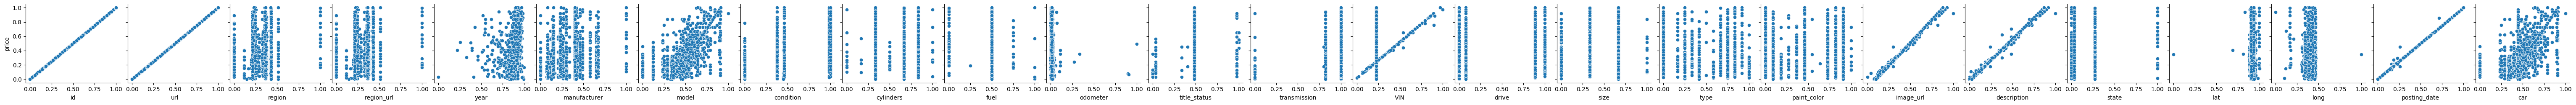

In [310]:
sns.pairplot(train,y_vars=['price'], x_vars=df.select_dtypes(include='number').columns.drop('price'), dropna=True)

<Axes: >

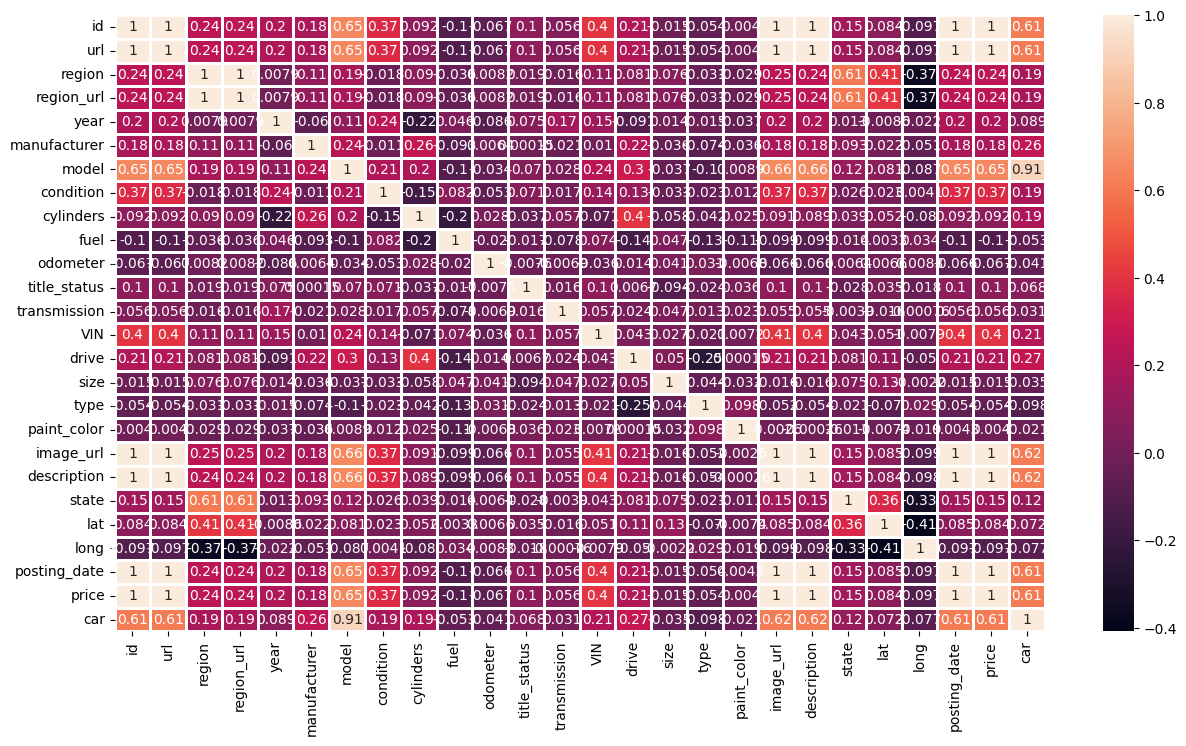

In [311]:
plt.figure(figsize=(15,8))

sns.heatmap(train.corr(numeric_only=True),annot=True,linewidths=2)

Based on this correlation information, let's select a threshold and remove all columns with a correlation of less than 0.2 with the target.

In [312]:
llindar = 0.2

correlations = train.corr()["price"]
seleccionades = correlations[correlations.abs() > llindar].index
train = train[seleccionades]
test = test[seleccionades]

train

,id,url,region,region_url,model,condition,VIN,drive,image_url,description,posting_date,price,car
0,0.297243,0.297243,0.290112,0.290112,0.511648,0.376146,0.224844,0.000000,0.332039,0.275619,0.297243,0.297243,0.511648
1,0.240000,0.240000,0.241712,0.241712,0.449839,0.982751,0.224844,0.077384,0.287532,0.227353,0.240000,0.240000,0.449839
2,0.259459,0.259459,0.335939,0.335939,0.451486,0.459118,0.224844,0.884605,0.302662,0.243761,0.259459,0.259459,0.451486
3,0.240541,0.240541,0.000000,0.000000,0.484455,1.000000,0.224844,0.077384,0.287953,0.227809,0.240541,0.240541,0.484455
4,0.242973,0.242973,0.268133,0.268133,0.124203,1.000000,0.224844,1.000000,0.283848,0.229860,0.242973,0.242973,0.444119
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,0.297027,0.297027,0.357542,0.357542,0.504349,0.459118,0.224844,0.884605,0.322055,0.264792,0.297027,0.297027,0.504349
1696,0.108108,0.108108,0.212901,0.212901,0.404137,0.376146,0.224844,0.000000,0.184987,0.116146,0.108108,0.108108,0.444119
1697,0.405405,0.405405,0.370811,0.370811,0.235030,1.000000,0.224844,0.077384,0.416135,0.366818,0.405405,0.405405,0.235030
1698,0.183784,0.183784,0.212901,0.212901,0.717089,0.376146,0.224844,0.000000,0.243824,0.179953,0.183784,0.183784,0.717089


The next step will be to separate the attributes from the target.

In [313]:

y_train = train["price"]
X_train = train.drop("price", axis="columns")

y_test = test["price"]
X_test = test.drop("price", axis="columns")

The next step is to deal with the NaNs in the data set, first in the training set and then in the test set to avoid data leakage.

In [314]:
X_train=X_train.fillna(X_train.mean())
X_test=X_test.fillna(X_test.mean())

## Model Selection

The final step will be to train the model and predict the target.

For this dataset, the chosen metric will be R² because it shows the relationship between the attributes and the price. It tends to perform bad with irrelevant attributes and outliers, but these have been removed in the previous steps.

In [315]:
repeated_kfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

pipe = Pipeline([('estimator', 'passthrough')])

param_grid = [
    {'estimator': [LinearRegression(n_jobs=-1)]}, 
    {'estimator': [Lasso()],
     'estimator__alpha': Real(0.001, 10, prior='log-uniform')},
    {'estimator': [Ridge()],
     'estimator__alpha': Real(0.001, 10, prior='log-uniform')},
    {'estimator': [SVR()],
     'estimator__C': Real(0.01, 100, prior='log-uniform'),
     'estimator__kernel': Categorical(['linear', 'rbf'])},
    {'estimator': [RandomForestRegressor(n_jobs=-1)],
     'estimator__n_estimators': Integer(50, 300),
     'estimator__max_depth': Integer(5, 30)}
]

search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_grid,
    cv=repeated_kfold,
    n_jobs=-1,
    scoring=make_scorer(r2_score),
    random_state=42
)

search.fit(X_train, y_train)

results = search.cv_results_
resultats = pd.DataFrame({
    'Model': [', '.join([f"{key.replace('estimator__', '')}: {value}" for key, value in params.items()]) for params in results['params']],
    'Score': results['mean_test_score'],
    'Temps': results['mean_fit_time'] 
})

pd.set_option('display.max_colwidth', None)
resultats = resultats.sort_values(by='Score', ascending=False).reset_index(drop=True)
resultats

,Model,Score,Temps
0,estimator: LinearRegression(n_jobs=-1),1.000000,0.005575
1,estimator: LinearRegression(n_jobs=-1),1.000000,0.003125
2,estimator: LinearRegression(n_jobs=-1),1.000000,0.003377
3,estimator: LinearRegression(n_jobs=-1),1.000000,0.002544
4,estimator: LinearRegression(n_jobs=-1),1.000000,0.002601
...,...,...,...
245,"estimator: Lasso(), alpha: 4.577324248754909",-0.004675,0.002386
246,"estimator: Lasso(), alpha: 0.35203533080523397",-0.004675,0.003020
247,"estimator: Lasso(), alpha: 0.09433568113576284",-0.004675,0.002367
248,"estimator: Lasso(), alpha: 2.1425632591165393",-0.004675,0.002399


## Final Analysis & Model Evaluation

In this chapter, the selected model will be analysed to determine its performance on the test set.

In [316]:
model = RandomForestRegressor(n_jobs=-1, max_depth=17, n_estimators=296, random_state=42)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

r2_test = r2_score(y_test, predictions_test)
mae_test = mean_absolute_error(y_test, predictions_test)

r2_train = r2_score(y_train, predictions_train)
mae_train = mean_absolute_error(y_train, predictions_train)


results = pd.DataFrame({
    'Metric': ['MAE','R²'],
    'Train Set': [mae_train, r2_train],
    'Test Set': [mae_test, r2_test]
})

results

,Metric,Train Set,Test Set
0,MAE,0.000134,0.000544
1,R²,0.999992,0.999792


The results indicate that the model performs exceptionally well on both the training and test sets.
The R² values are extremely high (≈ 0.99999 on training and ≈ 0.99979 on the test set), and the MAE values are extremely low, showing almost no difference between training and testing performance.

This tiny performance gap suggests that the model is not overfitting; instead, it generalizes unusually well to unseen data. Such behaviour may indicate:

* the data is highly structured or contains strong linear relationships,

* the features used perfectly encode the target variable,

* or there may be data leakage, meaning information from the target leaks into the input features.

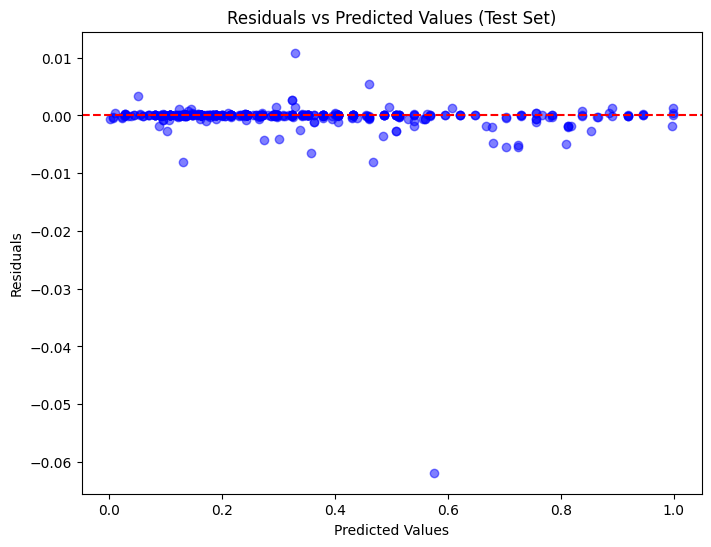

In [317]:
residuals_test = y_test - predictions_test
plt.figure(figsize=(8, 6))
plt.scatter(predictions_test, residuals_test, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values (Test Set)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In this graphic, the residuals are centered around zero but follow a conical pattern, which indicates that the model is performing well, though with some overfitting.

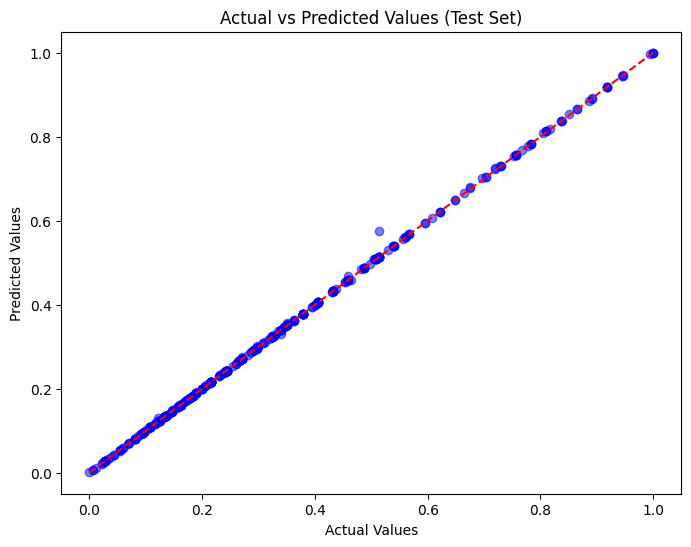

In [318]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions_test, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
plt.title('Actual vs Predicted Values (Test Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In this graphic, the actual and predicted values are close to the diagonal line, which indicates that the model is performing well.

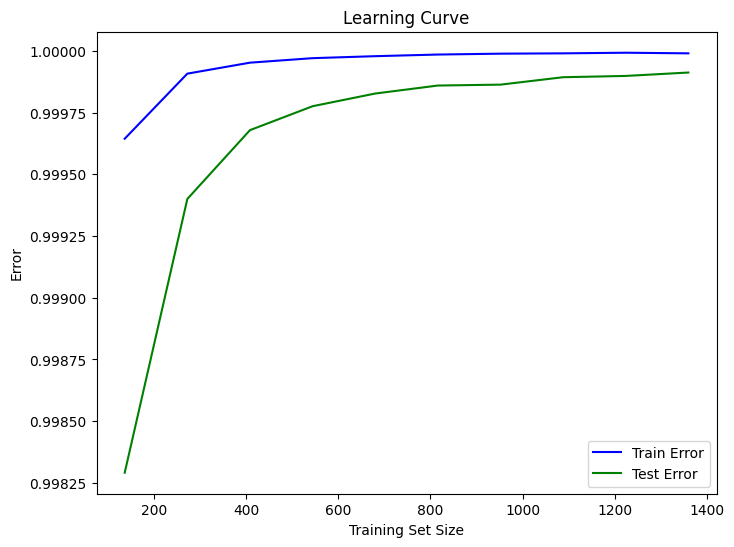

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Train Error', color='blue')
plt.plot(train_sizes, test_mean, label='Test Error', color='green')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.legend()
plt.show()

The learning curve shows that both the training error and the test error are extremely high (close to 1.0) and converge tightly as the training set size increases. This behavior indicates several important points about the model:

* The training error is already very high and barely decreases, even when more data is added.
This suggests that the model is not struggling with overfitting, since it is not achieving artificially good performance on the training set.

* The test error closely follows the training error, with a small and stable gap.
This means that the model generalizes extremely well to unseen data, and the performance remains consistent regardless of the amount of training data.

* The shape of the curves indicates good stability:

    - As the training size grows, both curves plateau near the same value.

    - There is no divergence between training and testing error.
    This reinforces the idea that the model is not overfitting or underfitting.


## Interpretation Summary

* The model performance is consistently excellent across all dataset sizes.

* No signs of overfitting: test and training errors move together.

* No signs of underfitting: the model achieves near-perfect accuracy even with small samples.

* The most plausible explanation for such perfect learning dynamics is that the dataset contains highly informative predictors or some unintentional leakage from the target variable into the features.